### Create a `weaviate` database from an unlabelled image dataset.

In [1]:
import weaviate

from impressive.caption import build_captioner, PredefinedModels, CaptionedImage
from impressive.database import add_images, get_image_collection, request_images

/home/s.garciamascaraque/Software/mambaforge/envs/impressive/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This notebook requirest some dependencies that are not present in the `impressive` package. To install them in the current environment, run the following cell.

In [2]:
!pip install datasets==2.20.0 matplotlib==3.9.0

/home/s.garciamascaraque/Software/mambaforge/envs/impressive/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=185841) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt

### Set some constants of the notebook

In [4]:
# Number of total images to store in the database
NUM_IMAGES_IN_DATASET: int = 128

# Number of captions per image. This allows more context per image. 
NUM_CAPTIONS_PER_IMAGE: int = 3

# Number of beam-search paths
NUM_BEAMS: int = 3

# Number of entries per batch in parallel processing
BATCH_SIZE: int = 8

# Device to use at inference time
DEVICE: str = "cuda"

### Obtain the dataset of images to process and the captioning function to caption them

In this particular case, we will use a database of [impressionist paintings](https://huggingface.co/datasets/chashaotm/impressionist_paintings). However, the notebook should work for any dataset
containing a collection of Pillow `Image` objects. To download the dataset, we will use the `datasets`
library. 

Once the dataset is loaded into memory, we will process it with a `Captioner` function (`Captioner: list[Image] -> list[list[str]]`). We can use the `build_captioner` function and the predefined `CaptioningModels` type to generate captions using [BLIP](https://huggingface.co/Salesforce/blip-image-captioning-base) or [GIT](https://huggingface.co/microsoft/git-base-coco) models. Extending the application to other captioning mechanisms should be simple.

⚠ **NOTE**: Loading the datasets and building the captioner will take time if the dataset and models are not present in the machine.

In [5]:
dataset = load_dataset("chashaotm/impressionist_paintings", split="train")

selected_model = PredefinedModels.MICROSOFT_GIT
get_captions = build_captioner(
    selected_model.processor,
    selected_model.inferer,
    num_beams=NUM_BEAMS,
    num_sequences=NUM_CAPTIONS_PER_IMAGE,
    batch_size=BATCH_SIZE,
    device=DEVICE,
)

### Caption the images in the dataset

We can use the `get_captions` function in the `impressive` package to caption our images. To store the captions and the images in a single container, we use the `CaptionedImage` container in the `impressive` package. This will also allow us to easily interface with the `weaviate` database due to its `as_base64` method.

⚠ **NOTE**: Creating the captions requires running the inference pass of the embedding model. As a result, it might take some time depending on the number of beams, sequences and images requested.

In [6]:
images = get_captions(dataset[:NUM_IMAGES_IN_DATASET]["image"])

We can use `matplotlib` to visualise some images and their captions.

Image 1: landscape with a field of flowers. landscape with a field of flowers and trees. landscape with a field of flowers.
Image 2: person in a garden by painting artist. person in a garden by painting artist.. person in a garden with a tree


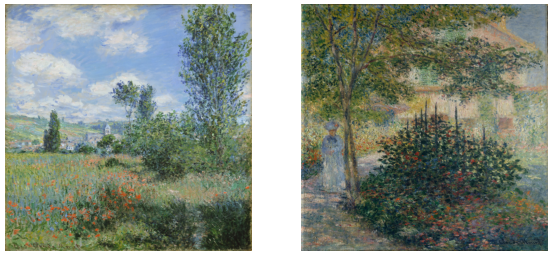

In [7]:
fig = plt.figure()
axs = [fig.add_subplot(1, 2, idx) for idx in range(1, 3)]

for idx, (axis, image) in enumerate(zip(axs, images, strict=False), start=1):
    axis.imshow(image.image)
    print(f"Image {idx}:", ". ".join(image.captions))
    axis.axis("off")


### Create the vector database and store the images

We have a dataset of images and their automatically-generated captions. As a result, we are now in the position of creating a vector database. We will use `weaviate` as our vector database implementation. We will use locally hosted models to ensure that no API keys are required. This also means that we need to run our own local instance of the `weaviate` server. Thankfully, we can easily run a `weaviate` instance through a Docker container. For more information about it, see [this blog post](https://weaviate.io/blog/local-rag-with-ollama-and-weaviate). In order to instantate the server, just run
```bash
docker run -p 8080:8080 -p 50051:50051 cr.weaviate.io/semitechnologies/weaviate:1.24.8
```
This will setup a `weaviate` server listening at the provided ports. Note that this server must be running throughout the whole application.

In [8]:
client = weaviate.connect_to_local()

Once the `weaviate` client is retrieved, we need to create a collection that will dictate the data that we want to store in the database. As we are planning on creating a natural language processing image-search application, we will store two things in the database: (1) the image itself as `base64` encoded string and (2) the vectorised caption.

In order to avoid costs and privacy problems when generating the captions, we will use a locally-hosted embedding model to produce our own vector embeddings. The simplest way of doing this is through `ollama`. To install `ollama`, just follow the instructions in its [webpage](https://ollama.com/).

We will use [`nomic-embed-text`](https://ollama.com/library/nomic-embed-text) model from `ollama`. This is a medium-size model with good performance that can be downloaded using:
```bash
ollama pull nomic-embed-text
```

Given the large size of the embedding space (768 dimensions), we will use binary quantisation to allow faster searches. Using binary quantisation increases the speed of the vector search at the cost of possible false positives/negatives. However, as our application is trying to search for images, we do not really care if some images are falsely retrieved. In addition, the large dimension of the space should diminish the effect of the quantisation.

In [9]:
client.collections.delete_all()
image_collection = get_image_collection(client, quantise_vectors=True)

We are now in the position of inserting some images into the dataset. To do so, we just need to call the `add_images` function in the `impressive` package with a collection of `CaptionedImage` objects to append.

In [10]:
add_images(image_collection, images, "nomic-embed-text")

We can check how many entries are there in the `Image` collection by calling the `len` method of the `Collection` object.

In [11]:
print(f"There are {len(image_collection)} entries in the `Image` collection.")

There are 128 entries in the `Image` collection.


### Testing the system by retrieving some images from it using NLP.

We can test the system by creating a prompt and querying it to the vector database. The vector database will retrieve a set of objects with the nearest vectors, which hopefully resemble the images with the given caption.

In [12]:
prompt: str = "Painting with a garden"
num_requested: int = 2

images = request_images(prompt, image_collection, "nomic-embed-text", num_images=num_requested)

We can visualise the retrieved images using `matplotlib`

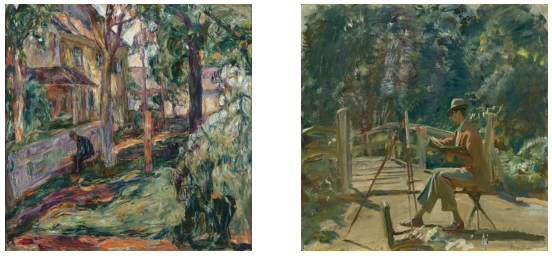

In [13]:
fig = plt.figure()
axs = [fig.add_subplot(1, num_requested, idx) for idx in range(1, num_requested + 1)]

for axis, image in zip(axs, images):
    axis.imshow(image.image)
    axis.axis("off")